In [52]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
%reload_ext autoreload

In [49]:
import seaborn as sns

In [2]:
import airfrans as af
import matplotlib.pyplot as plt

In [3]:
PATH_TO_DATASET = "/data/serrano/airfrans/Dataset/"

In [4]:
import numpy as np

In [5]:
import torch

In [ ]:
import os
import sys
from pathlib import Path
sys.path.append("/home/serrano/Projects/infinity/")

from src.data.dataset import GeometryDatasetFull, KEY_TO_INDEX, load_inr, load_modulations
from src.models.pointnet_2 import PointNet2
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

import einops
import json
import numpy as np
import torch
import torch.nn as nn
from graph_metalearning import outer_step
import yaml
from omegaconf import DictConfig

In [9]:
from experiments.inr import ModulatedPositionalEmbedder, PositionalEmbedder2

/home/serrano/Projects/INR_domain_decomposition/experiments/inr.py:146: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config/", config_name="basic.yaml")


In [11]:
from experiments.inr_sdf import ModulatedPositionalEmbedder as ModulatedPositionalEmbedderSDF

/home/serrano/Projects/INR_domain_decomposition/experiments/inr_sdf.py:136: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config/", config_name="basic.yaml")


# 1. Code Regression

In [12]:
task = "full"
data_to_encode = None
latent_dim = 256
scale_factor=1

In [13]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

trainset = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
#n = int(.9*len(manifest_train))

#print("len manifest train", manifest_train, n)

#trainset = manifest_train[:n] # was [:-n] ???

ntrain = len(trainset)
ntest = len(testset)

#default sample is none
trainset = GeometryDatasetFull(trainset, key=data_to_encode, latent_dim=latent_dim, scale_factor=scale_factor, norm=True, sample=None, n_boot=8000)
print("loaded train")
testset = GeometryDatasetFull(testset, key=data_to_encode, latent_dim=latent_dim, scale_factor=scale_factor, sample=None, n_boot=8000, coef_norm=trainset.coef_norm)
    

data_dir /data/serrano/airfrans/


100%|███████████████████████████████████████████████| 800/800 [05:19<00:00,  2.50it/s]


coef_norm (array([ 5.0064105e-01,  1.1181436e-02,  6.1606461e+01,  4.8862386e+00,
        2.3173042e-01, -1.6572434e-03, -8.5309672e-05], dtype=float32), array([ 0.7040743 ,  0.33643225, 17.757267  ,  6.2838936 ,  0.47521183,
        0.04159059,  0.06237248], dtype=float32), array([ 4.2485832e+01,  9.7596407e+00, -4.5211685e+02,  7.9553854e-04],
      dtype=float32), array([2.9667524e+01, 3.0894947e+01, 2.9469661e+03, 2.9265855e-03],
      dtype=float32))
loaded train


100%|███████████████████████████████████████████████| 200/200 [01:17<00:00,  2.57it/s]


coef_norm (array([ 5.0064105e-01,  1.1181436e-02,  6.1606461e+01,  4.8862386e+00,
        2.3173042e-01, -1.6572434e-03, -8.5309672e-05], dtype=float32), array([ 0.7040743 ,  0.33643225, 17.757267  ,  6.2838936 ,  0.47521183,
        0.04159059,  0.06237248], dtype=float32), array([ 4.2485832e+01,  9.7596407e+00, -4.5211685e+02,  7.9553854e-04],
      dtype=float32), array([2.9667524e+01, 3.0894947e+01, 2.9469661e+03, 2.9265855e-03],
      dtype=float32))


In [15]:
trainset.sample = "None"
testset.sample = "None"
trainset.n_points = 64000
testset.n_points = 64000

In [16]:
device = torch.device("cuda")

# load inr and modulations

#run_name_vx = "genial-waterfall-230"
#run_name_vy = "deft-durian-231"
#run_name_p = "cherry-pie-263" #"smart-waterfall-232"
#run_name_nu = "olive-sunset-271"#"lively-firebrand-233"

run_name_vx = "bright-totem-286"#"genial-waterfall-230"
run_name_vy = "devoted-puddle-287"#"deft-durian-231"
run_name_p = "serene-vortex-284"#"cherry-pie-263" #"smart-waterfall-232"
run_name_nu = "wandering-bee-288"#"olive-sunset-271"#"lively-firebrand-233"
run_name_sdf = "earnest-paper-289"
run_name_n = "astral-leaf-330"

inr_vx, alpha_vx = load_inr(run_name_vx, "vx")
inr_vy, alpha_vy = load_inr(run_name_vy, "vy")
inr_p, alpha_p = load_inr(run_name_p, "p")
inr_nu, alpha_nu = load_inr(run_name_nu, "nu")
inr_sdf, alpha_sdf = load_inr(run_name_sdf, "sdf", input_dim=2)
inr_n, alpha_n = load_inr(run_name_n, "n", input_dim=2)

mod_vx = load_modulations(trainset, testset, inr_vx, run_name_vx, "vx", alpha=alpha_vx)
mod_vy = load_modulations(trainset, testset, inr_vy, run_name_vy, "vy", alpha=alpha_vy)
mod_p = load_modulations(trainset, testset, inr_p, run_name_p, "p", alpha=alpha_p)
mod_nu = load_modulations(trainset, testset, inr_nu, run_name_nu, "nu", alpha=alpha_nu)
mod_sdf = load_modulations(trainset, testset, inr_sdf, run_name_sdf, "sdf", alpha=alpha_sdf, input_dim=2)
mod_n = load_modulations(trainset, testset, inr_n, run_name_n, "n", alpha=alpha_n, input_dim=2)

mu_vx = mod_vx['z_train'].mean(0)
sigma_vx = mod_vx['z_train'].std(0)
mu_vy = mod_vy['z_train'].mean(0)
sigma_vy = mod_vy['z_train'].std(0)
mu_p = mod_p['z_train'].mean(0)
sigma_p = mod_p['z_train'].std(0)
mu_nu = mod_nu['z_train'].mean(0)
sigma_nu = mod_nu['z_train'].std(0)
mu_sdf = mod_sdf['z_train'].mean(0)
sigma_sdf = mod_sdf['z_train'].std(0)
mu_n = mod_n['z_train'].mean(0)
sigma_n = mod_n['z_train'].std(0)

print('mu_sdf train', mu_sdf, sigma_sdf)
print('mu_sdf test', mod_sdf['z_test'].mean(0), mod_sdf["z_test"].std(0))

trainset.out_modulations['vx'] = (mod_vx['z_train'] - mu_vx) / sigma_vx
trainset.out_modulations['vy'] = (mod_vy['z_train'] - mu_vy) / sigma_vy
trainset.out_modulations['p'] = (mod_p['z_train'] - mu_p) / sigma_p
trainset.out_modulations['nu'] = (mod_nu['z_train'] - mu_nu) / sigma_nu
trainset.in_modulations['sdf'] = (mod_sdf['z_train'] - mu_sdf) / sigma_sdf
trainset.in_modulations['n'] = (mod_n['z_train'] - mu_n) / sigma_n

testset.out_modulations['vx'] = (mod_vx['z_test'] - mu_vx) / sigma_vx
testset.out_modulations['vy'] = (mod_vy['z_test'] - mu_vy) / sigma_vy
testset.out_modulations['p'] = (mod_p['z_test'] - mu_p) / sigma_p
testset.out_modulations['nu'] = (mod_nu['z_test'] - mu_nu) / sigma_nu
testset.in_modulations['sdf'] = (mod_sdf['z_test'] - mu_sdf) / sigma_sdf
testset.in_modulations['n'] = (mod_n['z_test'] - mu_n) / sigma_n

print('trainset', trainset.out_modulations)

output_dim 1
output_dim 1
output_dim 1
output_dim 1
output_dim 2
mu_sdf train tensor([ 3.4882e-04,  1.0591e-03, -5.0640e-04,  1.4222e-03,  1.6071e-03,
         2.0052e-03,  2.0339e-04, -7.4837e-04,  2.0183e-04, -3.9879e-04,
        -1.1601e-03,  3.4369e-04,  8.8468e-04, -2.3145e-05, -8.0328e-04,
         1.2743e-04,  1.9970e-03,  1.8397e-03,  3.9769e-04,  2.8044e-04,
         1.3352e-03, -9.9924e-04,  6.0198e-04,  7.2289e-04,  5.7688e-04,
        -1.5032e-03,  6.9427e-04, -2.6946e-04, -1.2560e-03,  1.7762e-03,
         9.7039e-04, -2.8272e-04,  1.9101e-04,  8.7776e-04,  2.1385e-05,
         2.3719e-04, -1.3750e-03,  1.3356e-03, -3.2772e-04, -3.3398e-04,
         1.3728e-04, -3.2553e-04,  8.7645e-05, -1.1324e-03,  1.5795e-03,
        -1.2181e-03,  8.7118e-04,  3.0854e-05, -7.7976e-04, -2.0957e-03,
         1.1800e-05, -5.1844e-04,  7.4073e-04,  1.0609e-03,  5.3563e-05,
         1.0883e-03,  1.5107e-03, -1.0032e-03,  1.3136e-03, -2.2845e-05,
         1.0837e-03, -2.2233e-04, -1.9110e-03,

In [24]:
#from coral.mlp import ResNet

In [36]:
from functools import partial
import torch.nn.functional as F


class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor([0.5]))

    def forward(self, x):
        return (x * torch.sigmoid_(x * F.softplus(self.beta))).div_(1.1)

ACTIVATIONS = {
    "relu": partial(nn.ReLU),
    "sigmoid": partial(nn.Sigmoid),
    "tanh": partial(nn.Tanh),
    "selu": partial(nn.SELU),
    "softplus": partial(nn.Softplus),
    "gelu": partial(nn.GELU),
    "swish": partial(Swish),
    "elu": partial(nn.ELU),
    "leakyrelu": partial(nn.LeakyReLU),
}

class ResBlock(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        drop_rate=0.0,
        activation="swish",
    ):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, input_dim)
        self.activation1 = ACTIVATIONS[activation]()
        self.activation2 = ACTIVATIONS[activation]()
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        eta = self.linear1(x)
        # eta = self.batch_norm1(eta)
        eta = self.linear2(self.activation1(eta))
        # no more dropout
        # out = self.activation2(x + self.dropout(eta))
        out = x + self.activation2(self.dropout(eta))
        return out


class ResNet(nn.Module):
    def __init__(
        self,
        input_dim=64,
        hidden_dim=64,
        output_dim=64,
        depth=2,
        dropout=0.0,
        activation="swish",
    ):
        super().__init__()
        net = [ResBlock(input_dim, hidden_dim, dropout, activation)]
        for _ in range(depth - 1):
            net.append(ResBlock(input_dim, hidden_dim, dropout, activation))

        self.net = nn.Sequential(*net)
        self.project_map = nn.Linear(input_dim, output_dim)

    def forward(self, z):
        out = self.net(z)
        out = self.project_map(out)

        return out



In [25]:
batch_size=64
batch_size_val=64

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)
# test

In [30]:
model = ResNet(input_dim=2*256+2,
    hidden_dim=256,
    output_dim=4*256,
    depth=4,
    dropout=0.0,
    activation='swish',
).cuda()

In [118]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [119]:
epochs=500

In [120]:
def groupby_mean(value:torch.Tensor, labels:torch.LongTensor) -> (torch.Tensor, torch.LongTensor):
    """Group-wise average for (sparse) grouped tensors
    
    Args:
        value (torch.Tensor): values to average (# samples, latent dimension)
        labels (torch.LongTensor): labels for embedding parameters (# samples,)
    
    Returns: 
        result (torch.Tensor): (# unique labels, latent dimension)
        new_labels (torch.LongTensor): (# unique labels,)
        
    Examples:
        >>> samples = torch.Tensor([
                             [0.15, 0.15, 0.15],    #-> group / class 1
                             [0.2, 0.2, 0.2],    #-> group / class 3
                             [0.4, 0.4, 0.4],    #-> group / class 3
                             [0.0, 0.0, 0.0]     #-> group / class 0
                      ])
        >>> labels = torch.LongTensor([1, 5, 5, 0])
        >>> result, new_labels = groupby_mean(samples, labels)
        
        >>> result
        tensor([[0.0000, 0.0000, 0.0000],
            [0.1500, 0.1500, 0.1500],
            [0.3000, 0.3000, 0.3000]])
            
        >>> new_labels
        tensor([0, 1, 5])
    """
    uniques = labels.unique().tolist()
    labels = labels.tolist()

    key_val = {key: val for key, val in zip(uniques, range(len(uniques)))}
    val_key = {val: key for key, val in zip(uniques, range(len(uniques)))}
    
    labels = torch.LongTensor(list(map(key_val.get, labels)))
    
    labels = labels.view(labels.size(0), 1).expand(-1, value.size(1))
    
    unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
    result = torch.zeros_like(unique_labels, dtype=torch.float).scatter_add_(0, labels, value)
    result = result / labels_count.float().unsqueeze(1)
    new_labels = torch.LongTensor(list(map(val_key.get, unique_labels[:, 0].tolist())))
    return result, new_labels

In [34]:
def select_inlet(values, batch, n_samples):
    out = torch.zeros(n_samples, 1).cuda()
    for j in range(n_samples):
        out[j, :] = values[batch == j][0]
    return out

In [122]:
graph.inlet_y[graph.batch==1][0]

tensor([0.2772], device='cuda:0')

In [123]:
best_loss = np.inf

mu_vx = mu_vx.cuda()
sigma_vx = sigma_vx.cuda()
mu_vy = mu_vy.cuda()
sigma_vy = sigma_vy.cuda()
mu_p = mu_p.cuda()
sigma_p = sigma_p.cuda()
mu_nu = mu_nu.cuda()
sigma_nu = sigma_nu.cuda()

for step in range(epochs):
    code_train_mse = 0
    code_test_mse = 0
    vx_train_mse = 0
    vx_test_mse = 0
    vy_train_mse = 0
    vy_test_mse = 0
    p_train_mse = 0
    p_test_mse = 0
    nu_train_mse = 0
    nu_test_mse = 0

    step_show = True

    for substep, (graph, idx) in enumerate(train_loader):
        model.train()
        graph = graph.cuda()
        n_samples = len(graph)
        
        inlet_x = select_inlet(graph.inlet_x, graph.batch, n_samples)
        inlet_y = select_inlet(graph.inlet_y, graph.batch, n_samples)
        
        ipt = torch.cat([graph.z_sdf, graph.z_n, inlet_x, inlet_y], axis=-1)
        pred = model(ipt)
        loss = ((pred - graph.z)**2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        code_train_mse += loss.item() * n_samples

        if step_show:
            num_points = n_samples * 4000
            mask = torch.randperm(graph.pos.shape[0])[:num_points]
            
            graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
            z_pred = pred.reshape(-1, 4, latent_dim)
            z_vx_pred = z_pred[:, 0, :] * sigma_vx + mu_vx
            z_vy_pred = z_pred[:, 1, :] * sigma_vy + mu_vy
            z_p_pred = z_pred[:, 2, :] * sigma_p + mu_p
            z_nu_pred = z_pred[:, 3, :] * sigma_nu + mu_nu

            with torch.no_grad():
                vx_pred = inr_vx.modulated_forward(graph.pos[mask], z_vx_pred[graph.batch[mask]])
                vy_pred = inr_vy.modulated_forward(graph.pos[mask], z_vy_pred[graph.batch[mask]])
                p_pred = inr_p.modulated_forward(graph.pos[mask], z_p_pred[graph.batch[mask]])
                nu_pred = inr_nu.modulated_forward(graph.pos[mask], z_nu_pred[graph.batch[mask]])

            vx_train_mse += ((vx_pred - graph.vx[mask])**2).mean().item()*n_samples
            vy_train_mse += ((vy_pred - graph.vy[mask])**2).mean().item()*n_samples
            p_train_mse += ((p_pred - graph.p[mask])**2).mean().item()*n_samples
            nu_train_mse += ((nu_pred - graph.nu[mask])**2).mean().item()*n_samples

    code_train_loss = code_train_mse / ntrain
    # scheduler.step(code_train_loss)
    if step%20==0:
        print("train code", step, code_train_loss)
    if step_show:
        vx_train_mse = vx_train_mse / ntrain
        vy_train_mse = vy_train_mse / ntrain
        p_train_mse = p_train_mse / ntrain
        nu_train_mse = nu_train_mse / ntrain
        print(f"train {step} vx: {vx_train_mse}, vy: {vy_train_mse}, p: {p_train_mse}, nu: {nu_train_mse}")

    if step_show:
        for substep, (graph, idx) in enumerate(test_loader):
            model.eval()
            graph = graph.cuda()
            n_samples = len(graph)

            inlet_x = select_inlet(graph.inlet_x, graph.batch, n_samples)
            inlet_y = select_inlet(graph.inlet_y, graph.batch, n_samples)
        
            ipt = torch.cat([graph.z_sdf, graph.z_n, inlet_x, inlet_y], axis=-1)
            pred = model(ipt)
            loss = ((pred - graph.z)**2).mean()
            code_test_mse += loss.item() * n_samples

            graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
            z_pred = pred.reshape(-1, 4, latent_dim)
            z_vx_pred = z_pred[:, 0, :] * sigma_vx + mu_vx
            z_vy_pred = z_pred[:, 1, :] * sigma_vy + mu_vy
            z_p_pred = z_pred[:, 2, :] * sigma_p + mu_p
            z_nu_pred = z_pred[:, 3, :] * sigma_nu + mu_nu
            
            num_points = n_samples * 4000
            mask = torch.randperm(graph.pos.shape[0])[:num_points]

            with torch.no_grad():
                vx_pred = inr_vx.modulated_forward(graph.pos[mask], z_vx_pred[graph.batch[mask]])
                vy_pred = inr_vy.modulated_forward(graph.pos[mask], z_vy_pred[graph.batch[mask]])
                p_pred = inr_p.modulated_forward(graph.pos[mask], z_p_pred[graph.batch[mask]])
                nu_pred = inr_nu.modulated_forward(graph.pos[mask], z_nu_pred[graph.batch[mask]])

            vx_test_mse += ((vx_pred - graph.vx[mask])**2).mean().item()*n_samples
            vy_test_mse += ((vy_pred - graph.vy[mask])**2).mean().item()*n_samples
            p_test_mse += ((p_pred - graph.p[mask])**2).mean().item()*n_samples
            nu_test_mse += ((nu_pred - graph.nu[mask])**2).mean().item()*n_samples

        code_test_loss = code_test_mse / ntest
        vx_test_mse = vx_test_mse / ntest
        vy_test_mse = vy_test_mse / ntest
        p_test_mse = p_test_mse / ntest
        nu_test_mse = nu_test_mse / ntest
        
        print(f"Test {step} code: {code_test_loss}, vx: {vx_test_mse}, vy: {vy_test_mse}, p: {p_test_mse}, nu: {nu_test_mse}")


train code 0 0.956963119506836
train 0 vx: 0.39510589361190795, vy: 0.6546864414215088, p: 0.7855349683761597, nu: 0.7543287944793701
Test 0 code: 0.8482943153381348, vx: 0.3677157711982727, vy: 0.6253042316436768, p: 0.6782466864585877, nu: 0.7088078927993774
train 1 vx: 0.36570674300193784, vy: 0.6123951005935669, p: 0.742597199678421, nu: 0.7351388812065125
Test 1 code: 0.7682571125030517, vx: 0.33661083817481996, vy: 0.5623594379425049, p: 0.6164484310150147, nu: 0.6953490829467773
train 2 vx: 0.32196896195411684, vy: 0.5310188019275666, p: 0.651061429977417, nu: 0.7097795486450196
Test 2 code: 0.7605981731414795, vx: 0.3033654582500458, vy: 0.49974894046783447, p: 0.6695883345603942, nu: 0.6420290899276734
train 3 vx: 0.26678022623062136, vy: 0.44225902199745176, p: 0.5834143996238709, nu: 0.6398312962055206
Test 3 code: 0.5664975225925446, vx: 0.22621068954467774, vy: 0.32386523485183716, p: 0.44414231181144714, nu: 0.5193375873565674
train 4 vx: 0.18002328038215637, vy: 0.293339

KeyboardInterrupt: 

In [ ]:
#torch.save(model.state_dict(), '/home/serrano/Projects/infinity/data/models/mlp/mlp_4_256_swish.pt')

In [ ]:
model.load_state_dict(torch.load('/home/serrano/Projects/infinity/data/models/mlp/mlp_4_256_swish.pt'))
model.eval()

ResNet(
  (net): Sequential(
    (0): ResBlock(
      (linear1): Linear(in_features=514, out_features=256, bias=True)
      (linear2): Linear(in_features=256, out_features=514, bias=True)
      (activation1): Swish()
      (activation2): Swish()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): ResBlock(
      (linear1): Linear(in_features=514, out_features=256, bias=True)
      (linear2): Linear(in_features=256, out_features=514, bias=True)
      (activation1): Swish()
      (activation2): Swish()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (2): ResBlock(
      (linear1): Linear(in_features=514, out_features=256, bias=True)
      (linear2): Linear(in_features=256, out_features=514, bias=True)
      (activation1): Swish()
      (activation2): Swish()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (3): ResBlock(
      (linear1): Linear(in_features=514, out_features=256, bias=True)
      (linear2): Linear(in_features=256, out_features=514, bias=True)
  

In [32]:
test_loader_full = DataLoader(testset, batch_size=2, shuffle=True)

In [43]:
code_train_mse = 0
code_test_mse = 0
vx_train_mse = 0
vx_test_mse = 0
vy_train_mse = 0
vy_test_mse = 0
p_train_mse = 0
p_test_mse = 0
nu_train_mse = 0
nu_test_mse = 0

mu_vx = mu_vx.cuda()
sigma_vx = sigma_vx.cuda()
mu_vy = mu_vy.cuda()
sigma_vy = sigma_vy.cuda()
mu_p = mu_p.cuda()
sigma_p = sigma_p.cuda()
mu_nu = mu_nu.cuda()
sigma_nu = sigma_nu.cuda()

for substep, (graph, idx) in enumerate(test_loader_full):
    model.eval()
    graph = graph.cuda()
    n_samples = len(graph)

    inlet_x = select_inlet(graph.inlet_x, graph.batch, n_samples)
    inlet_y = select_inlet(graph.inlet_y, graph.batch, n_samples)

    ipt = torch.cat([graph.z_sdf, graph.z_n, inlet_x, inlet_y], axis=-1)
    pred = model(ipt)
    loss = ((pred - graph.z)**2).mean()
    code_test_mse += loss.item() * n_samples

    graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    z_pred = pred.reshape(-1, 4, latent_dim)
    z_vx_pred = z_pred[:, 0, :] * sigma_vx + mu_vx
    z_vy_pred = z_pred[:, 1, :] * sigma_vy + mu_vy
    z_p_pred = z_pred[:, 2, :] * sigma_p + mu_p
    z_nu_pred = z_pred[:, 3, :] * sigma_nu + mu_nu

    mask = ...

    with torch.no_grad():
        vx_pred = inr_vx.modulated_forward(graph.pos[mask], z_vx_pred[graph.batch[mask]])
        vy_pred = inr_vy.modulated_forward(graph.pos[mask], z_vy_pred[graph.batch[mask]])
        p_pred = inr_p.modulated_forward(graph.pos[mask], z_p_pred[graph.batch[mask]])
        nu_pred = inr_nu.modulated_forward(graph.pos[mask], z_nu_pred[graph.batch[mask]])

    vx_test_mse += ((vx_pred - graph.vx[mask])**2).mean().item()*n_samples
    vy_test_mse += ((vy_pred - graph.vy[mask])**2).mean().item()*n_samples
    p_test_mse += ((p_pred - graph.p[mask])**2).mean().item()*n_samples
    nu_test_mse += ((nu_pred - graph.nu[mask])**2).mean().item()*n_samples

code_test_loss = code_test_mse / ntest
vx_test_mse = vx_test_mse / ntest
vy_test_mse = vy_test_mse / ntest
p_test_mse = p_test_mse / ntest
nu_test_mse = nu_test_mse / ntest

print(f"Test code: {code_test_loss}, vx: {vx_test_mse}, vy: {vy_test_mse}, p: {p_test_mse}, nu: {nu_test_mse}")

Test code: 0.014151356082875282, vx: 0.0008496071659465088, vy: 0.0008406731543072965, p: 0.0045912284469523, nu: 0.016573861669457984


In [45]:
vx_pred.shape

torch.Size([352830, 1])

In [42]:
code_test_mse = 0
vx_test_mse = 0
vy_test_mse = 0
p_test_mse = 0
nu_test_mse = 0

vx_test_mse_surf = 0
vy_test_mse_surf = 0
p_test_mse_surf = 0
nu_test_mse_surf = 0



for substep, (graph, idx) in enumerate(test_loader_full):
    model.eval()
    graph = graph.cuda()
    n_samples = len(graph)

    inlet_x = select_inlet(graph.inlet_x, graph.batch, n_samples)
    inlet_y = select_inlet(graph.inlet_y, graph.batch, n_samples)

    ipt = torch.cat([graph.z_sdf, graph.z_n, inlet_x, inlet_y], axis=-1)
    pred = model(ipt)
    loss = ((pred - graph.z)**2).mean()
    code_test_mse += loss.item() * n_samples

    graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    z_pred = pred.reshape(-1, 4, latent_dim)
    z_vx_pred = z_pred[:, 0, :] * sigma_vx + mu_vx
    z_vy_pred = z_pred[:, 1, :] * sigma_vy + mu_vy
    z_p_pred = z_pred[:, 2, :] * sigma_p + mu_p
    z_nu_pred = z_pred[:, 3, :] * sigma_nu + mu_nu

    
    with torch.no_grad():
        vx_pred = inr_vx.modulated_forward(graph.pos, z_vx_pred[graph.batch])
        vy_pred = inr_vy.modulated_forward(graph.pos, z_vy_pred[graph.batch])
        p_pred = inr_p.modulated_forward(graph.pos, z_p_pred[graph.batch])
        nu_pred = inr_nu.modulated_forward(graph.pos, z_nu_pred[graph.batch])
        
    mask_surf = graph.surface
    mask_volume = ~graph.surface
   
    vx_test_mse += ((vx_pred[mask_volume] - graph.vx[mask_volume])**2).mean().item()*n_samples
    vy_test_mse += ((vy_pred[mask_volume] - graph.vy[mask_volume])**2).mean().item()*n_samples
    p_test_mse += ((p_pred[mask_volume] - graph.p[mask_volume])**2).mean().item()*n_samples
    nu_test_mse += ((nu_pred[mask_volume] - graph.nu[mask_volume])**2).mean().item()*n_samples
    
    vx_test_mse_surf += ((vx_pred[mask_surf] - graph.vx[mask_surf])**2).mean().item()*n_samples
    vy_test_mse_surf += ((vy_pred[mask_surf] - graph.vy[mask_surf])**2).mean().item()*n_samples
    p_test_mse_surf += ((p_pred[mask_surf] - graph.p[mask_surf])**2).mean().item()*n_samples
    nu_test_mse_surf += ((nu_pred[mask_surf] - graph.nu[mask_surf])**2).mean().item()*n_samples
    

code_test_loss = code_test_mse / ntest
vx_test_mse = vx_test_mse / ntest
vy_test_mse = vy_test_mse / ntest
p_test_mse = p_test_mse / ntest
nu_test_mse = nu_test_mse / ntest

vx_test_mse_surf = vx_test_mse_surf / ntest
vy_test_mse_surf = vy_test_mse_surf / ntest
p_test_mse_surf = p_test_mse_surf / ntest
nu_test_mse_surf = nu_test_mse_surf / ntest

print(f"Test code: {code_test_loss}, Volume -> vx: {vx_test_mse}, vy: {vy_test_mse}, p: {p_test_mse}, nu: {nu_test_mse}")
print(f"Surface -> vx: {vx_test_mse_surf}, vy: {vy_test_mse_surf}, p: {p_test_mse_surf}, nu: {nu_test_mse_surf}")

Test code: 0.014151356074726208, Volume -> vx: 0.000857218633973389, vy: 0.0008472832424740773, p: 0.004628967964381445, nu: 0.016726694242679516
Surface -> vx: 0.0004896554130391451, vy: 0.000721594003480277, p: 0.014649171127093723, nu: 0.0001132481425338483


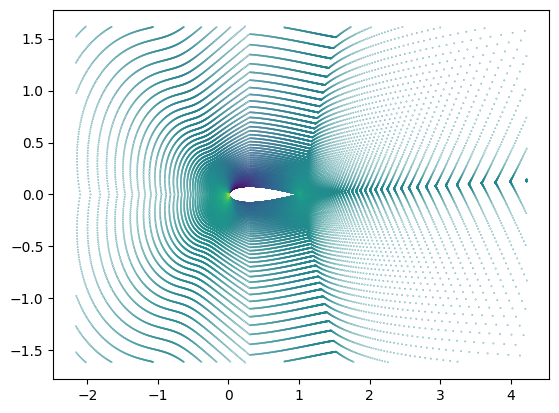

In [141]:
mask = graph.batch==0
plt.scatter(graph.pos[mask, 0].cpu(), graph.pos[mask, 1].cpu(), c=p_pred[mask].cpu().detach(), s=0.05)

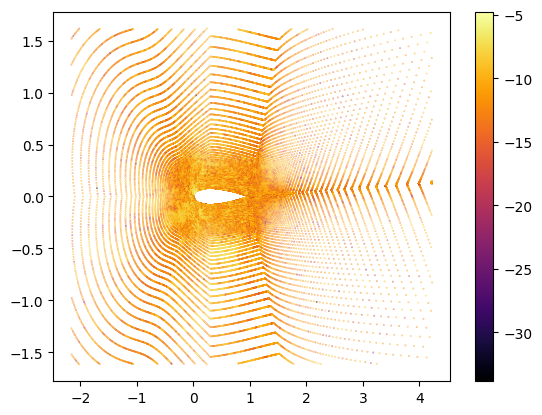

In [146]:
delta = torch.log((p_pred - graph.p)**2)
plt.scatter(graph.pos[mask, 0].cpu(), graph.pos[mask, 1].cpu(), c=delta[mask].cpu().detach(), s=0.05, cmap="inferno")
plt.colorbar()

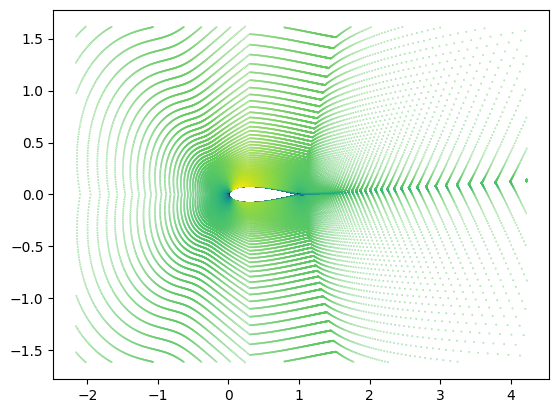

In [142]:
mask = graph.batch==0
plt.scatter(graph.pos[mask, 0].cpu(), graph.pos[mask, 1].cpu(), c=vx_pred[mask].cpu().detach(), s=0.05)

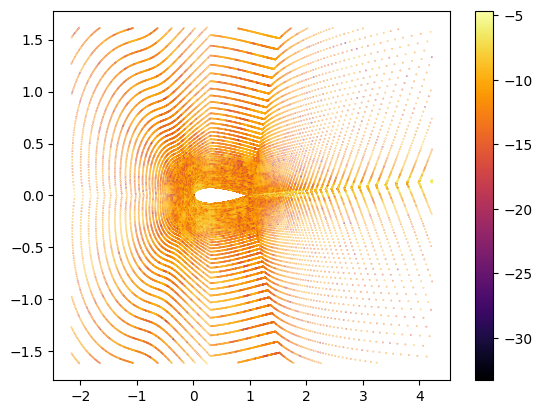

In [150]:
delta = torch.log((vx_pred - graph.vx)**2)
plt.scatter(graph.pos[mask, 0].cpu(), graph.pos[mask, 1].cpu(), c=delta[mask].cpu().detach(), s=0.05, cmap="inferno")
plt.colorbar()

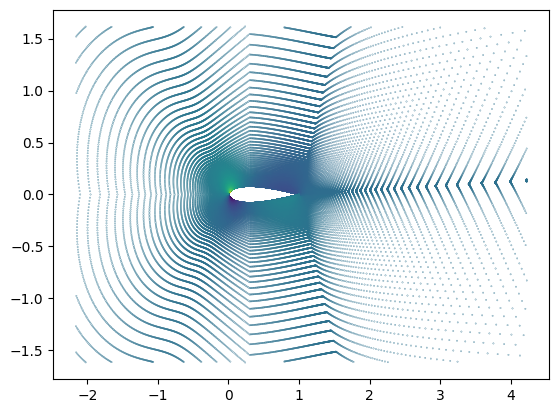

In [139]:
mask = graph.batch==0
plt.scatter(graph.pos[mask, 0].cpu(), graph.pos[mask, 1].cpu(), c=vy_pred[mask].cpu().detach(), s=0.05)

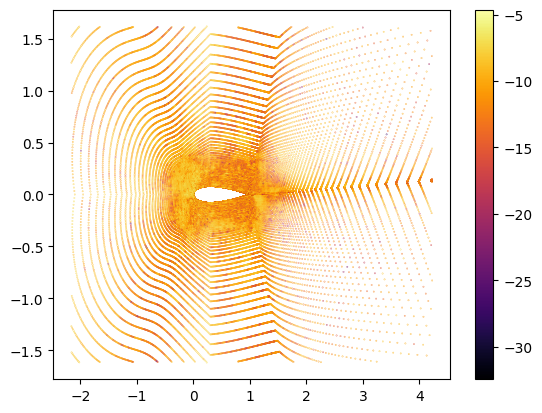

In [151]:
delta = torch.log((vy_pred - graph.vy)**2)
plt.scatter(graph.pos[mask, 0].cpu(), graph.pos[mask, 1].cpu(), c=delta[mask].cpu().detach(), s=0.05, cmap="inferno")
plt.colorbar()

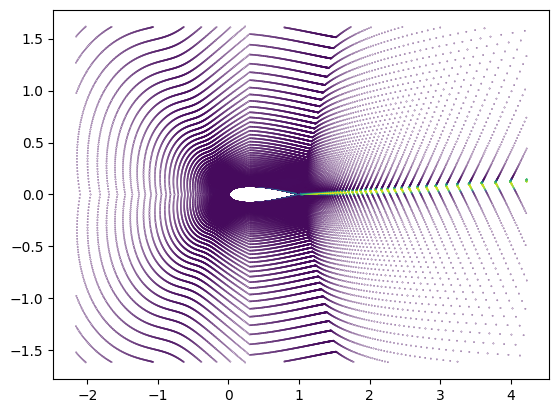

In [140]:
mask = graph.batch==0
plt.scatter(graph.pos[mask, 0].cpu(), graph.pos[mask, 1].cpu(), c=nu_pred[mask].cpu().detach(), s=0.05)

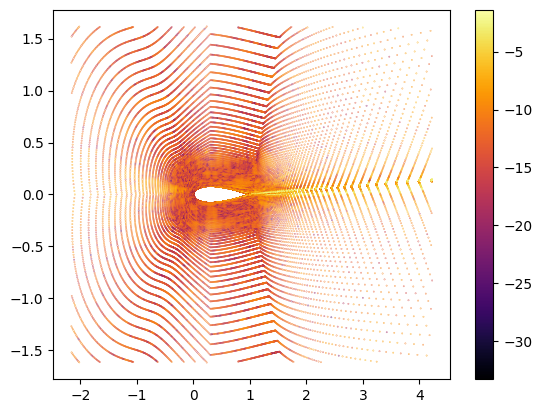

In [152]:
delta = torch.log((nu_pred - graph.nu)**2)
plt.scatter(graph.pos[mask, 0].cpu(), graph.pos[mask, 1].cpu(), c=delta[mask].cpu().detach(), s=0.05, cmap="inferno")
plt.colorbar()

# 2. Obtain physics results

In [117]:
from src.utils.metrics import Airfoil_mean, Airfoil_test, Compute_coefficients, rel_err

In [60]:
from src.utils import metrics_NACA

In [62]:
test_loader_full = DataLoader(testset, batch_size=1, shuffle=False)

In [61]:
testset_pred = []

In [69]:
for substep, (graph, idx) in enumerate(test_loader_full):
    model.eval()
    graph = graph.cuda()
    n_samples=1

    inlet_x = select_inlet(graph.inlet_x, graph.batch, n_samples)
    inlet_y = select_inlet(graph.inlet_y, graph.batch, n_samples)

    ipt = torch.cat([graph.z_sdf, graph.z_n, inlet_x, inlet_y], axis=-1)
    pred = model(ipt)
    loss = ((pred - graph.z)**2).mean()
    code_test_mse += loss.item() * n_samples

    graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    z_pred = pred.reshape(-1, 4, latent_dim)
    z_vx_pred = z_pred[:, 0, :] * sigma_vx + mu_vx
    z_vy_pred = z_pred[:, 1, :] * sigma_vy + mu_vy
    z_p_pred = z_pred[:, 2, :] * sigma_p + mu_p
    z_nu_pred = z_pred[:, 3, :] * sigma_nu + mu_nu

    mask = ...

    with torch.no_grad():
        vx_pred = inr_vx.modulated_forward(graph.pos[mask], z_vx_pred[graph.batch[mask]])
        vy_pred = inr_vy.modulated_forward(graph.pos[mask], z_vy_pred[graph.batch[mask]])
        p_pred = inr_p.modulated_forward(graph.pos[mask], z_p_pred[graph.batch[mask]])
        nu_pred = inr_nu.modulated_forward(graph.pos[mask], z_nu_pred[graph.batch[mask]])

    vx_test_mse += ((vx_pred - graph.vx[mask])**2).mean().item()
    vy_test_mse += ((vy_pred - graph.vy[mask])**2).mean().item()
    p_test_mse += ((p_pred - graph.p[mask])**2).mean().item()
    nu_test_mse += ((nu_pred - graph.nu[mask])**2).mean().item()
    
    graph_pred = Data(x=torch.cat([graph.pos, graph.inlet_x, graph.inlet_y, graph.sdf, graph.nx, graph.ny], axis=-1))
    graph_pred.y = torch.cat([vx_pred, vy_pred, p_pred, nu_pred], axis=-1) 
    graph_pred.surface = graph.surface
    
    testset_pred.append(graph_pred.cpu())

In [70]:
testset_pred[0]

Data(x=[179033, 8], y=[179033, 4], surface=[179033])

In [84]:
# Compute scores and all metrics for a 
sns.set()
path_in = '/data/serrano/airfrans/Dataset/'
with open(path_in + 'manifest.json', 'r') as f:
    manifest = json.load(f)

task = "full"
test_dataset_list = manifest[task + '_test']
#idx = random.sample(range(len(test_dataset)), k = n_test)
#idx.sort()

#test_dataset_vtk = Dataset(test_dataset, sample = None, coef_norm = coef_norm)   
#test_loader = DataLoader(test_dataset_vtk, shuffle = False)

criterion = "MSE"
if criterion == 'MSE':
    criterion = nn.MSELoss(reduction = 'none')
elif criterion == 'MAE':
    criterion = nn.L1Loss(reduction = 'none')

In [88]:
from tqdm import tqdm
import pyvista as pv

In [89]:
coef_norm = trainset.coef_norm

In [96]:
testset_pred[1]

Data(x=[197146, 8], y=[197146, 4], surface=[197146])

In [103]:
def Airfoil_test(internal, airfoil, outs, coef_norm, bool_surf):
    # Produce multiple copies of a simulation for different predictions.
    # stocker les internals, airfoils, calculer le wss, calculer le drag, le lift, plot pressure coef, plot skin friction coef, plot drag/drag, plot lift/lift
    # calcul spearsman coef, boundary layer
    internals = []
    airfoils = []
    for out in outs:
        intern = internal.copy()
        aerofoil = airfoil.copy()

        point_mesh = intern.points[bool_surf, :2]
        point_surf = aerofoil.points[:, :2]
        #print('out', out)
        out = (out*(coef_norm[3] + 1e-8) + coef_norm[2]).numpy()
        out[bool_surf.numpy(), :2] = np.zeros_like(out[bool_surf.numpy(), :2])
        out[bool_surf.numpy(), 3] = np.zeros_like(out[bool_surf.numpy(), 3])
        intern.point_data['U'][:, :2] = out[:, :2]
        intern.point_data['p'] = out[:, 2]
        intern.point_data['nut'] = out[:, 3]

        surf_p = intern.point_data['p'][bool_surf]
        surf_p = reorganize(point_mesh, point_surf, surf_p)
        aerofoil.point_data['p'] = surf_p

        intern = intern.ptc(pass_point_data = True) 
        aerofoil = aerofoil.ptc(pass_point_data = True)       

        internals.append(intern)
        airfoils.append(aerofoil)
    
    return internals, airfoils

In [156]:
scores_vol = []
scores_surf = []
scores_force = []
scores_p = []
scores_wss = []
internals = []
airfoils = []
true_internals = []
true_airfoils = []
times = []
true_coefs = []
pred_coefs = []
#for i in range(len(models[0])):
#model = [models[n][i] for n in range(1)]

# len(models) -> 1
# len(model) -> 1

avg_loss_per_var = np.zeros((1, 4))
avg_loss = np.zeros(1)
avg_loss_surf_var = np.zeros((1, 4))
avg_loss_vol_var = np.zeros((1, 4))
avg_loss_surf = np.zeros(1)
avg_loss_vol = np.zeros(1)
avg_rel_err_force = np.zeros((1, 2))
avg_loss_p = np.zeros((1))
avg_loss_wss = np.zeros((1, 2))
internal = []
airfoil = []
pred_coef = []

for j, data in enumerate(tqdm(test_loader_full)):
    Uinf, angle = float(test_dataset_list[j].split('_')[2]), float(test_dataset_list[j].split('_')[3])    
    print(f"uinf: {Uinf}, angle: {angle}")
    data[0].y = torch.cat([data[0].vx, data[0].vy, data[0].p, data[0].nu], axis=-1)

    # to replace >>>>> outs, tim = Infer_test(device, model, hparams, data, coef_norm = coef_norm)
    outs = [testset_pred[j]]
    # times.append(tim)
    intern = pv.read('/data/serrano/airfrans/Dataset/' + test_dataset_list[j] + '/' + test_dataset_list[j] + '_internal.vtu')
    aerofoil = pv.read('/data/serrano/airfrans/Dataset/' + test_dataset_list[j] + '/' + test_dataset_list[j] + '_aerofoil.vtp')
    tc, true_intern, true_airfoil = Compute_coefficients([intern], [aerofoil], data[0].surface, Uinf, angle, keep_vtk = True)
    tc, true_intern, true_airfoil = tc[0], true_intern[0], true_airfoil[0]
    intern, aerofoil = Airfoil_test(intern, aerofoil, [out.y for out in outs], coef_norm, data[0].surface)
    pc, intern, aerofoil = Compute_coefficients(intern, aerofoil, data[0].surface, Uinf, angle, keep_vtk = True)

    true_coefs.append(tc)
    pred_coef.append(pc)

    internal.append(intern)
    airfoil.append(aerofoil)
    true_internals.append(true_intern)
    true_airfoils.append(true_airfoil)

    for n, out in enumerate(outs):
        #print('out', out.y.shape)
        #print('target', data[0].y.shape)
        loss_per_var = criterion(out.y, data[0].y).mean(dim = 0)
        loss = loss_per_var.mean()
        loss_surf_var = criterion(out.y[data[0].surface, :], data[0].y[data[0].surface, :]).mean(dim = 0)
        loss_vol_var = criterion(out.y[~data[0].surface, :], data[0].y[~data[0].surface, :]).mean(dim = 0)
        loss_surf = loss_surf_var.mean()
        loss_vol = loss_vol_var.mean()

        avg_loss_per_var[n] += loss_per_var.cpu().numpy()
        avg_loss[n] += loss.cpu().numpy()
        avg_loss_surf_var[n] += loss_surf_var.cpu().numpy()
        avg_loss_vol_var[n] += loss_vol_var.cpu().numpy()
        avg_loss_surf[n] += loss_surf.cpu().numpy()
        avg_loss_vol[n] += loss_vol.cpu().numpy()
        avg_rel_err_force[n] += rel_err(tc, pc[n])
        avg_loss_wss[n] += rel_err(true_airfoil.point_data['wallShearStress'], aerofoil[n].point_data['wallShearStress']).mean(axis = 0)
        avg_loss_p[n] += rel_err(true_airfoil.point_data['p'], aerofoil[n].point_data['p']).mean(axis = 0)

  0%|                                                                               | 0/200 [00:00<?, ?it/s]

uinf: 31.812, angle: 1.334


  0%|▎                                                                      | 1/200 [00:01<06:02,  1.82s/it]

uinf: 39.741, angle: 14.642


  1%|▋                                                                      | 2/200 [00:03<06:22,  1.93s/it]

uinf: 85.752, angle: 6.341


  2%|█                                                                      | 3/200 [00:05<06:10,  1.88s/it]

uinf: 80.247, angle: 1.078


  2%|█▍                                                                     | 4/200 [00:07<06:09,  1.88s/it]

uinf: 61.728, angle: 9.994


  2%|█▊                                                                     | 5/200 [00:09<05:59,  1.84s/it]

uinf: 65.202, angle: -3.411


  3%|██▏                                                                    | 6/200 [00:11<05:56,  1.84s/it]

uinf: 58.451, angle: -4.262


  4%|██▍                                                                    | 7/200 [00:13<05:58,  1.86s/it]

uinf: 86.75, angle: 14.13


  4%|██▊                                                                    | 8/200 [00:14<05:56,  1.85s/it]

uinf: 37.251, angle: 6.299


  4%|███▏                                                                   | 9/200 [00:16<05:52,  1.85s/it]

uinf: 43.677, angle: -1.764


  5%|███▌                                                                  | 10/200 [00:18<05:53,  1.86s/it]

uinf: 90.574, angle: 8.095


  6%|███▊                                                                  | 11/200 [00:20<06:07,  1.95s/it]

uinf: 90.102, angle: 0.155


  6%|████▏                                                                 | 12/200 [00:22<05:58,  1.91s/it]

uinf: 40.676, angle: -2.366


  6%|████▌                                                                 | 13/200 [00:24<05:46,  1.85s/it]

uinf: 57.682, angle: -2.023


  7%|████▉                                                                 | 14/200 [00:26<05:36,  1.81s/it]

uinf: 60.295, angle: -0.953


  8%|█████▎                                                                | 15/200 [00:27<05:41,  1.85s/it]

uinf: 82.537, angle: 6.598


  8%|█████▌                                                                | 16/200 [00:29<05:43,  1.87s/it]

uinf: 61.676, angle: 0.83


  8%|█████▉                                                                | 17/200 [00:31<05:42,  1.87s/it]

uinf: 37.191, angle: 5.448


  9%|██████▎                                                               | 18/200 [00:33<05:42,  1.88s/it]

uinf: 62.644, angle: 9.845


 10%|██████▋                                                               | 19/200 [00:35<05:44,  1.90s/it]

uinf: 86.326, angle: 9.572


 10%|███████                                                               | 20/200 [00:37<05:42,  1.90s/it]

uinf: 79.502, angle: 3.387


 10%|███████▎                                                              | 21/200 [00:39<05:44,  1.92s/it]

uinf: 33.33, angle: 14.375


 11%|███████▋                                                              | 22/200 [00:41<05:46,  1.94s/it]

uinf: 88.307, angle: -4.328


 12%|████████                                                              | 23/200 [00:43<05:43,  1.94s/it]

uinf: 39.019, angle: -2.224


 12%|████████▍                                                             | 24/200 [00:45<05:45,  1.96s/it]

uinf: 65.717, angle: 9.69


 12%|████████▊                                                             | 25/200 [00:47<05:43,  1.96s/it]

uinf: 73.967, angle: -1.295


 13%|█████████                                                             | 26/200 [00:49<05:47,  1.99s/it]

uinf: 93.213, angle: 3.79


 14%|█████████▍                                                            | 27/200 [00:51<05:53,  2.04s/it]

uinf: 68.096, angle: 11.613


 14%|█████████▊                                                            | 28/200 [00:54<06:42,  2.34s/it]

uinf: 55.312, angle: 11.209


 14%|██████████▏                                                           | 29/200 [00:56<06:34,  2.31s/it]

uinf: 50.26, angle: 6.348


 15%|██████████▌                                                           | 30/200 [00:59<06:44,  2.38s/it]

uinf: 56.549, angle: -4.731


 16%|██████████▊                                                           | 31/200 [01:01<06:31,  2.32s/it]

uinf: 56.39, angle: -3.195


 16%|███████████▏                                                          | 32/200 [01:03<06:21,  2.27s/it]

uinf: 90.415, angle: 14.684


 16%|███████████▌                                                          | 33/200 [01:05<06:02,  2.17s/it]

uinf: 50.859, angle: 8.157


 17%|███████████▉                                                          | 34/200 [01:07<05:48,  2.10s/it]

uinf: 52.403, angle: 3.314


 18%|████████████▎                                                         | 35/200 [01:09<05:55,  2.15s/it]

uinf: 42.852, angle: 2.968


 18%|████████████▌                                                         | 36/200 [01:11<05:45,  2.10s/it]

uinf: 44.995, angle: 5.582


 18%|████████████▉                                                         | 37/200 [01:13<05:43,  2.11s/it]

uinf: 78.164, angle: -1.095


 19%|█████████████▎                                                        | 38/200 [01:16<05:44,  2.12s/it]

uinf: 39.31, angle: 8.883


 20%|█████████████▋                                                        | 39/200 [01:18<05:44,  2.14s/it]

uinf: 54.238, angle: 7.911


 20%|██████████████                                                        | 40/200 [01:20<05:50,  2.19s/it]

uinf: 64.173, angle: 1.751


 20%|██████████████▎                                                       | 41/200 [01:22<05:42,  2.15s/it]

uinf: 47.569, angle: 6.831


 21%|██████████████▋                                                       | 42/200 [01:24<05:39,  2.15s/it]

uinf: 74.924, angle: 10.466


 22%|███████████████                                                       | 43/200 [01:26<05:32,  2.12s/it]

uinf: 53.794, angle: -1.06


 22%|███████████████▍                                                      | 44/200 [01:28<05:29,  2.11s/it]

uinf: 64.341, angle: 8.316


 22%|███████████████▊                                                      | 45/200 [01:31<05:33,  2.15s/it]

uinf: 59.266, angle: -3.994


 23%|████████████████                                                      | 46/200 [01:33<05:28,  2.14s/it]

uinf: 52.195, angle: -1.473


 24%|████████████████▍                                                     | 47/200 [01:35<05:24,  2.12s/it]

uinf: 62.723, angle: -1.384


 24%|████████████████▊                                                     | 48/200 [01:37<05:22,  2.12s/it]

uinf: 35.49, angle: 10.54


 24%|█████████████████▏                                                    | 49/200 [01:39<05:20,  2.12s/it]

uinf: 65.137, angle: -0.857


 25%|█████████████████▌                                                    | 50/200 [01:41<05:22,  2.15s/it]

uinf: 51.101, angle: 7.597


 26%|█████████████████▊                                                    | 51/200 [01:43<05:17,  2.13s/it]

uinf: 32.137, angle: 12.122


 26%|██████████████████▏                                                   | 52/200 [01:45<05:04,  2.06s/it]

uinf: 43.705, angle: 13.408


 26%|██████████████████▌                                                   | 53/200 [01:47<05:03,  2.06s/it]

uinf: 87.291, angle: 7.541


 27%|██████████████████▉                                                   | 54/200 [01:50<05:05,  2.09s/it]

uinf: 70.983, angle: -3.536


 28%|███████████████████▎                                                  | 55/200 [01:52<05:04,  2.10s/it]

uinf: 38.731, angle: 9.437


 28%|███████████████████▌                                                  | 56/200 [01:54<04:58,  2.07s/it]

uinf: 62.607, angle: 8.578


 28%|███████████████████▉                                                  | 57/200 [01:56<04:53,  2.05s/it]

uinf: 78.105, angle: -0.517


 29%|████████████████████▎                                                 | 58/200 [01:58<04:48,  2.03s/it]

uinf: 40.386, angle: 12.852


 30%|████████████████████▋                                                 | 59/200 [02:00<04:49,  2.05s/it]

uinf: 61.301, angle: 0.196


 30%|█████████████████████                                                 | 60/200 [02:02<04:45,  2.04s/it]

uinf: 62.562, angle: 4.388


 30%|█████████████████████▎                                                | 61/200 [02:04<04:42,  2.03s/it]

uinf: 59.75, angle: 10.766


 31%|█████████████████████▋                                                | 62/200 [02:06<04:39,  2.02s/it]

uinf: 63.402, angle: 0.697


 32%|██████████████████████                                                | 63/200 [02:08<04:38,  2.04s/it]

uinf: 34.806, angle: 8.99


 32%|██████████████████████▍                                               | 64/200 [02:10<04:32,  2.00s/it]

uinf: 64.144, angle: 0.932


 32%|██████████████████████▊                                               | 65/200 [02:12<04:39,  2.07s/it]

uinf: 38.268, angle: -1.682


 33%|███████████████████████                                               | 66/200 [02:14<04:30,  2.02s/it]

uinf: 32.432, angle: 14.036


 34%|███████████████████████▍                                              | 67/200 [02:16<04:43,  2.13s/it]

uinf: 32.892, angle: -0.128


 34%|███████████████████████▊                                              | 68/200 [02:18<04:39,  2.12s/it]

uinf: 57.812, angle: 8.479


 34%|████████████████████████▏                                             | 69/200 [02:21<04:40,  2.14s/it]

uinf: 63.433, angle: 6.161


 35%|████████████████████████▌                                             | 70/200 [02:23<04:35,  2.12s/it]

uinf: 92.85, angle: -3.031


 36%|████████████████████████▊                                             | 71/200 [02:25<04:28,  2.08s/it]

uinf: 89.976, angle: -1.312


 36%|█████████████████████████▏                                            | 72/200 [02:26<04:15,  1.99s/it]

uinf: 81.645, angle: 7.57


 36%|█████████████████████████▌                                            | 73/200 [02:28<04:06,  1.94s/it]

uinf: 65.002, angle: 11.743


 37%|█████████████████████████▉                                            | 74/200 [02:30<04:04,  1.94s/it]

uinf: 74.272, angle: 3.789


 38%|██████████████████████████▎                                           | 75/200 [02:32<04:04,  1.95s/it]

uinf: 78.068, angle: -2.258


 38%|██████████████████████████▌                                           | 76/200 [02:34<04:03,  1.96s/it]

uinf: 74.044, angle: -0.131


 38%|██████████████████████████▉                                           | 77/200 [02:36<04:02,  1.97s/it]

uinf: 64.163, angle: 5.971


 39%|███████████████████████████▎                                          | 78/200 [02:38<03:59,  1.97s/it]

uinf: 36.155, angle: 8.69


 40%|███████████████████████████▋                                          | 79/200 [02:40<03:55,  1.95s/it]

uinf: 64.12, angle: 14.249


 40%|████████████████████████████                                          | 80/200 [02:42<03:57,  1.98s/it]

uinf: 39.204, angle: 6.325


 40%|████████████████████████████▎                                         | 81/200 [02:44<03:53,  1.96s/it]

uinf: 92.722, angle: -0.765


 41%|████████████████████████████▋                                         | 82/200 [02:46<03:50,  1.96s/it]

uinf: 86.166, angle: 13.513


 42%|█████████████████████████████                                         | 83/200 [02:48<03:47,  1.94s/it]

uinf: 76.324, angle: 13.23


 42%|█████████████████████████████▍                                        | 84/200 [02:50<03:56,  2.04s/it]

uinf: 59.682, angle: -3.433


 42%|█████████████████████████████▊                                        | 85/200 [02:52<03:48,  1.99s/it]

uinf: 41.044, angle: -0.773


 43%|██████████████████████████████                                        | 86/200 [02:54<03:43,  1.96s/it]

uinf: 89.338, angle: 1.322


 44%|██████████████████████████████▍                                       | 87/200 [02:56<03:36,  1.91s/it]

uinf: 74.904, angle: 11.928


 44%|██████████████████████████████▊                                       | 88/200 [02:58<03:37,  1.94s/it]

uinf: 55.077, angle: 8.22


 44%|███████████████████████████████▏                                      | 89/200 [03:00<03:32,  1.91s/it]

uinf: 81.138, angle: 14.286


 45%|███████████████████████████████▌                                      | 90/200 [03:01<03:31,  1.92s/it]

uinf: 43.22, angle: 2.151


 46%|███████████████████████████████▊                                      | 91/200 [03:03<03:29,  1.92s/it]

uinf: 82.474, angle: -3.457


 46%|████████████████████████████████▏                                     | 92/200 [03:05<03:25,  1.90s/it]

uinf: 60.845, angle: 6.456


 46%|████████████████████████████████▌                                     | 93/200 [03:07<03:21,  1.88s/it]

uinf: 76.343, angle: 0.584


 47%|████████████████████████████████▉                                     | 94/200 [03:09<03:19,  1.88s/it]

uinf: 89.324, angle: 10.448


 48%|█████████████████████████████████▎                                    | 95/200 [03:11<03:22,  1.93s/it]

uinf: 48.233, angle: 10.709


 48%|█████████████████████████████████▌                                    | 96/200 [03:13<03:19,  1.91s/it]

uinf: 42.34, angle: 1.874


 48%|█████████████████████████████████▉                                    | 97/200 [03:15<03:18,  1.93s/it]

uinf: 53.943, angle: 5.835


 49%|██████████████████████████████████▎                                   | 98/200 [03:17<03:20,  1.96s/it]

uinf: 59.225, angle: -4.585


 50%|██████████████████████████████████▋                                   | 99/200 [03:19<03:14,  1.92s/it]

uinf: 80.611, angle: -1.934


 50%|██████████████████████████████████▌                                  | 100/200 [03:21<03:13,  1.93s/it]

uinf: 89.398, angle: 3.144


 50%|██████████████████████████████████▊                                  | 101/200 [03:23<03:13,  1.95s/it]

uinf: 61.642, angle: 14.277


 51%|███████████████████████████████████▏                                 | 102/200 [03:25<03:10,  1.94s/it]

uinf: 59.921, angle: -3.747


 52%|███████████████████████████████████▌                                 | 103/200 [03:27<03:12,  1.99s/it]

uinf: 66.817, angle: 3.963


 52%|███████████████████████████████████▉                                 | 104/200 [03:29<03:08,  1.96s/it]

uinf: 45.238, angle: 3.827


 52%|████████████████████████████████████▏                                | 105/200 [03:31<03:07,  1.97s/it]

uinf: 89.65, angle: 8.631


 53%|████████████████████████████████████▌                                | 106/200 [03:33<03:11,  2.04s/it]

uinf: 46.385, angle: 3.538


 54%|████████████████████████████████████▉                                | 107/200 [03:35<03:05,  2.00s/it]

uinf: 55.308, angle: 7.17


 54%|█████████████████████████████████████▎                               | 108/200 [03:37<03:04,  2.01s/it]

uinf: 86.999, angle: 4.281


 55%|█████████████████████████████████████▌                               | 109/200 [03:39<03:05,  2.04s/it]

uinf: 48.999, angle: 7.352


 55%|█████████████████████████████████████▉                               | 110/200 [03:41<02:54,  1.94s/it]

uinf: 84.137, angle: 13.126


 56%|██████████████████████████████████████▎                              | 111/200 [03:43<02:55,  1.97s/it]

uinf: 71.226, angle: 3.333


 56%|██████████████████████████████████████▋                              | 112/200 [03:45<02:52,  1.96s/it]

uinf: 81.349, angle: 2.289


 56%|██████████████████████████████████████▉                              | 113/200 [03:46<02:48,  1.94s/it]

uinf: 47.789, angle: 3.639


 57%|███████████████████████████████████████▎                             | 114/200 [03:48<02:44,  1.91s/it]

uinf: 75.101, angle: -3.321


 57%|███████████████████████████████████████▋                             | 115/200 [03:50<02:37,  1.85s/it]

uinf: 89.523, angle: 6.267


 58%|████████████████████████████████████████                             | 116/200 [03:52<02:32,  1.81s/it]

uinf: 39.45, angle: 1.609


 58%|████████████████████████████████████████▎                            | 117/200 [03:54<02:32,  1.84s/it]

uinf: 91.532, angle: 9.129


 59%|████████████████████████████████████████▋                            | 118/200 [03:56<02:34,  1.88s/it]

uinf: 79.552, angle: 4.065


 60%|█████████████████████████████████████████                            | 119/200 [03:57<02:32,  1.89s/it]

uinf: 86.061, angle: 2.445


 60%|█████████████████████████████████████████▍                           | 120/200 [03:59<02:32,  1.91s/it]

uinf: 63.757, angle: 8.194


 60%|█████████████████████████████████████████▋                           | 121/200 [04:01<02:30,  1.90s/it]

uinf: 67.706, angle: -0.1


 61%|██████████████████████████████████████████                           | 122/200 [04:03<02:25,  1.87s/it]

uinf: 43.007, angle: 1.079


 62%|██████████████████████████████████████████▍                          | 123/200 [04:05<02:30,  1.95s/it]

uinf: 39.497, angle: -4.94


 62%|██████████████████████████████████████████▊                          | 124/200 [04:07<02:27,  1.94s/it]

uinf: 81.115, angle: -3.901


 62%|███████████████████████████████████████████▏                         | 125/200 [04:09<02:27,  1.97s/it]

uinf: 50.206, angle: 7.207


 63%|███████████████████████████████████████████▍                         | 126/200 [04:11<02:22,  1.92s/it]

uinf: 65.163, angle: 5.647


 64%|███████████████████████████████████████████▊                         | 127/200 [04:13<02:22,  1.95s/it]

uinf: 78.501, angle: 14.686


 64%|████████████████████████████████████████████▏                        | 128/200 [04:16<02:49,  2.35s/it]

uinf: 31.863, angle: -1.58


 64%|████████████████████████████████████████████▌                        | 129/200 [04:18<02:36,  2.21s/it]

uinf: 58.859, angle: 13.222


 65%|████████████████████████████████████████████▊                        | 130/200 [04:20<02:28,  2.13s/it]

uinf: 45.931, angle: 0.03


 66%|█████████████████████████████████████████████▏                       | 131/200 [04:22<02:21,  2.06s/it]

uinf: 90.197, angle: 2.112


 66%|█████████████████████████████████████████████▌                       | 132/200 [04:24<02:18,  2.03s/it]

uinf: 59.086, angle: 9.398


 66%|█████████████████████████████████████████████▉                       | 133/200 [04:26<02:15,  2.02s/it]

uinf: 46.153, angle: 14.283


 67%|██████████████████████████████████████████████▏                      | 134/200 [04:28<02:12,  2.00s/it]

uinf: 58.936, angle: 8.84


 68%|██████████████████████████████████████████████▌                      | 135/200 [04:30<02:09,  2.00s/it]

uinf: 90.036, angle: -0.06


 68%|██████████████████████████████████████████████▉                      | 136/200 [04:32<02:04,  1.94s/it]

uinf: 87.86, angle: 9.36


 68%|███████████████████████████████████████████████▎                     | 137/200 [04:34<02:02,  1.94s/it]

uinf: 52.518, angle: 12.114


 69%|███████████████████████████████████████████████▌                     | 138/200 [04:36<02:02,  1.98s/it]

uinf: 47.017, angle: -4.369


 70%|███████████████████████████████████████████████▉                     | 139/200 [04:38<01:57,  1.92s/it]

uinf: 63.019, angle: 8.632


 70%|████████████████████████████████████████████████▎                    | 140/200 [04:40<01:58,  1.97s/it]

uinf: 91.602, angle: 10.45


 70%|████████████████████████████████████████████████▋                    | 141/200 [04:42<01:57,  1.99s/it]

uinf: 73.068, angle: 7.205


 71%|████████████████████████████████████████████████▉                    | 142/200 [04:44<01:55,  1.99s/it]

uinf: 87.122, angle: 9.543


 72%|█████████████████████████████████████████████████▎                   | 143/200 [04:46<01:52,  1.97s/it]

uinf: 35.507, angle: 5.777


 72%|█████████████████████████████████████████████████▋                   | 144/200 [04:48<01:51,  1.99s/it]

uinf: 37.291, angle: -2.407


 72%|██████████████████████████████████████████████████                   | 145/200 [04:50<01:50,  2.01s/it]

uinf: 68.256, angle: 7.603


 73%|██████████████████████████████████████████████████▎                  | 146/200 [04:52<01:49,  2.03s/it]

uinf: 81.551, angle: -0.327


 74%|██████████████████████████████████████████████████▋                  | 147/200 [04:54<01:48,  2.05s/it]

uinf: 45.331, angle: 8.408


 74%|███████████████████████████████████████████████████                  | 148/200 [04:56<01:47,  2.07s/it]

uinf: 69.687, angle: 7.38


 74%|███████████████████████████████████████████████████▍                 | 149/200 [04:58<01:43,  2.04s/it]

uinf: 35.44, angle: 14.039


 75%|███████████████████████████████████████████████████▊                 | 150/200 [05:00<01:41,  2.03s/it]

uinf: 69.059, angle: 3.724


 76%|████████████████████████████████████████████████████                 | 151/200 [05:02<01:39,  2.04s/it]

uinf: 72.141, angle: 12.23


 76%|████████████████████████████████████████████████████▍                | 152/200 [05:04<01:37,  2.04s/it]

uinf: 43.071, angle: 6.024


 76%|████████████████████████████████████████████████████▊                | 153/200 [05:06<01:31,  1.95s/it]

uinf: 58.57, angle: -1.369


 77%|█████████████████████████████████████████████████████▏               | 154/200 [05:08<01:30,  1.97s/it]

uinf: 83.38, angle: -2.726


 78%|█████████████████████████████████████████████████████▍               | 155/200 [05:10<01:28,  1.96s/it]

uinf: 40.889, angle: 1.007


 78%|█████████████████████████████████████████████████████▊               | 156/200 [05:12<01:25,  1.95s/it]

uinf: 32.66, angle: 1.2


 78%|██████████████████████████████████████████████████████▏              | 157/200 [05:14<01:23,  1.94s/it]

uinf: 89.947, angle: 11.582


 79%|██████████████████████████████████████████████████████▌              | 158/200 [05:15<01:21,  1.94s/it]

uinf: 43.485, angle: 4.923


 80%|██████████████████████████████████████████████████████▊              | 159/200 [05:17<01:19,  1.93s/it]

uinf: 64.171, angle: 10.66


 80%|███████████████████████████████████████████████████████▏             | 160/200 [05:19<01:16,  1.92s/it]

uinf: 44.227, angle: -4.876


 80%|███████████████████████████████████████████████████████▌             | 161/200 [05:21<01:13,  1.90s/it]

uinf: 82.21, angle: 13.462


 81%|███████████████████████████████████████████████████████▉             | 162/200 [05:23<01:12,  1.91s/it]

uinf: 73.692, angle: 11.215


 82%|████████████████████████████████████████████████████████▏            | 163/200 [05:25<01:09,  1.87s/it]

uinf: 33.012, angle: 6.968


 82%|████████████████████████████████████████████████████████▌            | 164/200 [05:27<01:06,  1.85s/it]

uinf: 80.715, angle: 4.776


 82%|████████████████████████████████████████████████████████▉            | 165/200 [05:29<01:05,  1.87s/it]

uinf: 35.516, angle: -1.874


 83%|█████████████████████████████████████████████████████████▎           | 166/200 [05:30<01:03,  1.87s/it]

uinf: 59.789, angle: 11.839


 84%|█████████████████████████████████████████████████████████▌           | 167/200 [05:32<01:02,  1.90s/it]

uinf: 45.059, angle: 0.002


 84%|█████████████████████████████████████████████████████████▉           | 168/200 [05:34<00:59,  1.85s/it]

uinf: 41.987, angle: 6.655


 84%|██████████████████████████████████████████████████████████▎          | 169/200 [05:36<00:58,  1.88s/it]

uinf: 40.539, angle: -2.945


 85%|██████████████████████████████████████████████████████████▋          | 170/200 [05:38<00:57,  1.92s/it]

uinf: 41.46, angle: 9.803


 86%|██████████████████████████████████████████████████████████▉          | 171/200 [05:40<00:54,  1.89s/it]

uinf: 58.038, angle: -4.278


 86%|███████████████████████████████████████████████████████████▎         | 172/200 [05:42<00:53,  1.93s/it]

uinf: 55.738, angle: 5.776


 86%|███████████████████████████████████████████████████████████▋         | 173/200 [05:44<00:51,  1.89s/it]

uinf: 59.54, angle: 7.06


 87%|████████████████████████████████████████████████████████████         | 174/200 [05:46<00:49,  1.92s/it]

uinf: 86.745, angle: 2.442


 88%|████████████████████████████████████████████████████████████▍        | 175/200 [05:48<00:48,  1.94s/it]

uinf: 44.638, angle: -2.059


 88%|████████████████████████████████████████████████████████████▋        | 176/200 [05:50<00:46,  1.95s/it]

uinf: 60.541, angle: 2.401


 88%|█████████████████████████████████████████████████████████████        | 177/200 [05:52<00:44,  1.94s/it]

uinf: 70.349, angle: 11.188


 89%|█████████████████████████████████████████████████████████████▍       | 178/200 [05:54<00:43,  2.00s/it]

uinf: 72.611, angle: -2.163


 90%|█████████████████████████████████████████████████████████████▊       | 179/200 [05:56<00:41,  1.98s/it]

uinf: 71.208, angle: 7.824


 90%|██████████████████████████████████████████████████████████████       | 180/200 [05:58<00:38,  1.93s/it]

uinf: 54.799, angle: -2.718


 90%|██████████████████████████████████████████████████████████████▍      | 181/200 [05:59<00:35,  1.86s/it]

uinf: 87.005, angle: 2.047


 91%|██████████████████████████████████████████████████████████████▊      | 182/200 [06:01<00:33,  1.85s/it]

uinf: 82.708, angle: 1.905


 92%|███████████████████████████████████████████████████████████████▏     | 183/200 [06:03<00:31,  1.88s/it]

uinf: 88.059, angle: 8.244


 92%|███████████████████████████████████████████████████████████████▍     | 184/200 [06:05<00:30,  1.89s/it]

uinf: 49.099, angle: 14.068


 92%|███████████████████████████████████████████████████████████████▊     | 185/200 [06:07<00:28,  1.93s/it]

uinf: 59.56, angle: -4.362


 93%|████████████████████████████████████████████████████████████████▏    | 186/200 [06:09<00:27,  1.94s/it]

uinf: 70.291, angle: 2.396


 94%|████████████████████████████████████████████████████████████████▌    | 187/200 [06:11<00:24,  1.90s/it]

uinf: 73.459, angle: -1.971


 94%|████████████████████████████████████████████████████████████████▊    | 188/200 [06:13<00:23,  1.92s/it]

uinf: 63.558, angle: 0.533


 94%|█████████████████████████████████████████████████████████████████▏   | 189/200 [06:14<00:20,  1.88s/it]

uinf: 80.801, angle: 6.115


 95%|█████████████████████████████████████████████████████████████████▌   | 190/200 [06:17<00:19,  1.94s/it]

uinf: 39.01, angle: 8.67


 96%|█████████████████████████████████████████████████████████████████▉   | 191/200 [06:18<00:17,  1.94s/it]

uinf: 33.984, angle: -1.17


 96%|██████████████████████████████████████████████████████████████████▏  | 192/200 [06:20<00:15,  1.93s/it]

uinf: 60.182, angle: 1.471


 96%|██████████████████████████████████████████████████████████████████▌  | 193/200 [06:22<00:13,  1.95s/it]

uinf: 59.245, angle: 2.515


 97%|██████████████████████████████████████████████████████████████████▉  | 194/200 [06:24<00:11,  1.93s/it]

uinf: 70.228, angle: 11.772


 98%|███████████████████████████████████████████████████████████████████▎ | 195/200 [06:26<00:09,  1.94s/it]

uinf: 74.033, angle: -0.601


 98%|███████████████████████████████████████████████████████████████████▌ | 196/200 [06:28<00:07,  1.96s/it]

uinf: 88.876, angle: 8.65


 98%|███████████████████████████████████████████████████████████████████▉ | 197/200 [06:30<00:05,  1.96s/it]

uinf: 53.509, angle: 6.273


 99%|████████████████████████████████████████████████████████████████████▎| 198/200 [06:32<00:03,  1.95s/it]

uinf: 64.598, angle: 8.654


100%|████████████████████████████████████████████████████████████████████▋| 199/200 [06:34<00:01,  1.89s/it]

uinf: 67.783, angle: -2.041


100%|█████████████████████████████████████████████████████████████████████| 200/200 [06:36<00:00,  1.98s/it]


In [157]:
import scipy as sc
NU = np.array(1.56e-5)

In [158]:
len(test_loader_full)

200

In [159]:
ntest=200

In [160]:
internals.append(internal)
airfoils.append(airfoil)
pred_coefs.append(pred_coef)        

score_var = np.array(avg_loss_per_var)/ntest
score = np.array(avg_loss)/ntest
score_surf_var = np.array(avg_loss_surf_var)/ntest
score_vol_var = np.array(avg_loss_vol_var)/ntest
score_surf = np.array(avg_loss_surf)/ntest
score_vol = np.array(avg_loss_vol)/ntest
score_force = np.array(avg_rel_err_force)/ntest
score_p = np.array(avg_loss_p)/ntest
score_wss = np.array(avg_loss_wss)/ntest

score = score_surf + score_vol
scores_vol.append(score_vol_var)
scores_surf.append(score_surf_var)
scores_force.append(score_force)
scores_p.append(score_p)
scores_wss.append(score_wss)

In [161]:
scores_vol = np.array(scores_vol)
scores_surf = np.array(scores_surf)
scores_force = np.array(scores_force)
scores_p = np.array(scores_p)
scores_wss = np.array(scores_wss)
times = np.array(times)
true_coefs = np.array(true_coefs)
pred_coefs = np.array(pred_coefs)
pred_coefs_mean = pred_coefs.mean(axis = 0)
pred_coefs_std = pred_coefs.std(axis = 0)

In [171]:
true_coefs.shape

(200, 2)

In [175]:
rel_err(true_coefs[:, 0], pred_coefs_mean.squeeze()[:, 0]).mean()

0.3723676958337348

In [176]:
rel_err(true_coefs[:, 1], pred_coefs_mean.squeeze()[:, 1]).mean()

0.08653070510787271

In [180]:
true_coefs[:10, 0]

array([0.01161865, 0.02647341, 0.00929934, 0.00724772, 0.01485893,
       0.00887962, 0.01079508, 0.02069848, 0.01300655, 0.01092653])

In [179]:
pred_coefs.squeeze()[:10, 0]

array([ 0.00133266,  0.03051184,  0.00803097,  0.00806534,  0.01356104,
        0.00890426,  0.00705125,  0.01948239,  0.02190742, -0.00032718])

In [162]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [163]:
spear_coefs = []
for j in range(pred_coefs.shape[0]):
    spear_coef = []
    for k in range(pred_coefs.shape[2]):
        spear_drag = sc.stats.spearmanr(true_coefs[:, 0], pred_coefs[j, :, k, 0])[0]
        spear_lift = sc.stats.spearmanr(true_coefs[:, 1], pred_coefs[j, :, k, 1])[0]
        spear_coef.append([spear_drag, spear_lift])
    spear_coefs.append(spear_coef)
spear_coefs = np.array(spear_coefs)

with open('results/score.json', 'w') as f:
    json.dump(
        {   
            'mean_time': times.mean(axis = 0),
            'std_time': times.std(axis = 0),
            'mean_score_vol': scores_vol.mean(axis = 0),
            'std_score_vol': scores_vol.std(axis = 0),
            'mean_score_surf': scores_surf.mean(axis = 0),
            'std_score_surf': scores_surf.std(axis = 0),
            'mean_rel_p': scores_p.mean(axis = 0),
            'std_rel_p': scores_p.std(axis = 0),
            'mean_rel_wss': scores_wss.mean(axis = 0),
            'std_rel_wss': scores_wss.std(axis = 0),
            'mean_score_force': scores_force.mean(axis = 0),
            'std_score_force': scores_force.std(axis = 0),
            'spearman_coef_mean': spear_coefs.mean(axis = 0),
            'spearman_coef_std': spear_coefs.std(axis = 0)
        }, f, indent = 4, cls = NumpyEncoder
    )

/tmp/ipykernel_941122/3110468890.py:14: RuntimeWarning: Mean of empty slice.
  'mean_time': times.mean(axis = 0),
/data/serrano/miniconda3/wisp/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/serrano/miniconda3/wisp/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/serrano/miniconda3/wisp/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/serrano/miniconda3/wisp/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [164]:
{   
            'mean_time': times.mean(axis = 0),
            'std_time': times.std(axis = 0),
            'mean_score_vol': scores_vol.mean(axis = 0),
            'std_score_vol': scores_vol.std(axis = 0),
            'mean_score_surf': scores_surf.mean(axis = 0),
            'std_score_surf': scores_surf.std(axis = 0),
            'mean_rel_p': scores_p.mean(axis = 0),
            'std_rel_p': scores_p.std(axis = 0),
            'mean_rel_wss': scores_wss.mean(axis = 0),
            'std_rel_wss': scores_wss.std(axis = 0),
            'mean_score_force': scores_force.mean(axis = 0),
            'std_score_force': scores_force.std(axis = 0),
            'spearman_coef_mean': spear_coefs.mean(axis = 0),
            'spearman_coef_std': spear_coefs.std(axis = 0)
        }

/tmp/ipykernel_941122/9912429.py:2: RuntimeWarning: Mean of empty slice.
  'mean_time': times.mean(axis = 0),


{'mean_time': nan,
 'std_time': nan,
 'mean_score_vol': array([[0.00085628, 0.00084962, 0.00455948, 0.0168007 ]]),
 'std_score_vol': array([[0., 0., 0., 0.]]),
 'mean_score_surf': array([[0.00048711, 0.00072272, 0.01434391, 0.00011374]]),
 'std_score_surf': array([[0., 0., 0., 0.]]),
 'mean_rel_p': array([10.82139551]),
 'std_rel_p': array([0.]),
 'mean_rel_wss': array([[25.16007128, 37.76246904]]),
 'std_rel_wss': array([[0., 0.]]),
 'mean_score_force': array([[0.3723677 , 0.08653071]]),
 'std_score_force': array([[0., 0.]]),
 'spearman_coef_mean': array([[0.59449936, 0.99743344]]),
 'spearman_coef_std': array([[0., 0.]])}

In [149]:
scores_vol.mean(axis = 0)

array([[0.0428138 , 0.04248109, 0.22797402, 0.84003506]])

In [146]:
# fig, ax = plt.subplots(1, 2, figsize = (20, 10))
# # ax[2].scatter(true_coefs[:, 1], true_coefs[:, 0], label = 'True', color = 'black', marker = 's')
# model_name = ['MLP', 'GraphSAGE', 'PointNet', 'GUNet']
# for l, model in enumerate(model_name):
#     ax[0].errorbar(true_coefs[:, 0], pred_coefs_mean[:, l, 0], yerr = pred_coefs_std[:, l, 0], fmt = 'x', capsize = 3, label = model)
#     ax[1].errorbar(true_coefs[:, 1], pred_coefs_mean[:, l, 1], yerr = pred_coefs_std[:, l, 1], fmt = 'x', capsize = 3, label = model)
#     # ax[2].errorbar(pred_coefs_mean[:, l, 1], pred_coefs_mean[:, l, 0], xerr = pred_coefs_std[:, l, 1], yerr = pred_coefs_std[:, l, 0], fmt = 'x', capsize = 3, label = model)
# ax[0].set_xlabel('True ' + r'$C_D$')
# ax[0].set_ylabel('Predicted ' + r'$C_D$')
# ax[1].set_xlabel('True ' + r'$C_L$')
# ax[1].set_ylabel('Predicted ' + r'$C_L$')
# # ax[2].set_xlabel(r'$C_L$')
# # ax[2].set_ylabel(r'$C_D$')
# ax[0].legend(loc = 'best')
# ax[1].legend(loc = 'best')
# # ax[2].legend(loc = 'best')
# fig.savefig('metrics/coefs.png', bbox_inches = 'tight', dpi = 150)
x_bl = [.2, .4, .6, .8]
surf_coefs = []
true_surf_coefs = []
bls = []
true_bls = []
for i in range(len(internals[0])):
    aero_name = test_dataset_list[i]
    true_internal = true_internals[i]
    true_airfoil = true_airfoils[i]
    surf_coef = []
    bl = []
    for j in range(len(internals[0][0])):
        internal_mean, airfoil_mean = Airfoil_mean([internals[k][i][j] for k in range(len(internals))], [airfoils[k][i][j] for k in range(len(airfoils))])
        internal_mean.save(test_dataset_list[i] + '_' + str(j) + '.vtu')
        surf_coef.append(np.array(metrics_NACA.surface_coefficients(airfoil_mean, aero_name)))
        b = []
        for x in x_bl:
            b.append(np.array(metrics_NACA.boundary_layer(airfoil_mean, internal_mean, aero_name, x)))
        bl.append(np.array(b))
    true_surf_coefs.append(np.array(metrics_NACA.surface_coefficients(true_airfoil, aero_name)))
    true_bl = []
    for x in x_bl:
        true_bl.append(np.array(metrics_NACA.boundary_layer(true_airfoil, true_internal, aero_name, x)))
    true_bls.append(np.array(true_bl))
    surf_coefs.append(np.array(surf_coef))
    bls.append(np.array(bl))

true_bls = np.array(true_bls)
bls = np.array(bls)

ValueError: zero-size array to reduction operation minimum which has no identity

In [147]:
airfoil_mean

PolyData (0x7fcfad823520)
  N Cells:    915
  N Points:   915
  N Strips:   0
  X Bounds:   -4.182e-04, 1.000e+00
  Y Bounds:   -2.902e-02, 1.159e-01
  Z Bounds:   5.000e-01, 5.000e-01
  N Arrays:   12

In [ ]:
coeff_norm[3]

In [125]:
pred_coefs.shape

(1, 200, 1, 2)

In [22]:
test_loader = DataLoader(testset, batch_size=batch_size_val, shuffle=True)

In [23]:
run_name = "frosty-shadow-316"
#"denim-cosmos-278"
point_net_train = torch.load(f"/data/serrano/functa2functa/airfrans/inr/nu/{run_name}.pt")

In [30]:
from torch_geometric.nn import MLP
from src.models.pointnet_2 import GlobalSAModule, SAModule
class PointNet2SDF(torch.nn.Module):
    """
    adapted from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/pointnet2_classification.py
    """
    def __init__(self, input_dim=2, node_features=5, output_dim=1024, dropout=0.25, latent_dim=256):
        super().__init__()
        self.input_dim = input_dim
        self.dropout = dropout
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.node_features = node_features

        # Input channels account for both `pos` and node features.
        self.sa1_module = SAModule(0.5, 0.2, MLP([self.node_features + self.input_dim, 32, 64])) # was 0.4, 0.2
        self.sa2_module = SAModule(0.25, 0.4, MLP([64 + self.input_dim, 64, 128])) # 0.25, 0.4
        self.sa3_module = GlobalSAModule(MLP([128 + self.input_dim, 256, 256]))

        self.mlp = MLP([256 + 256, 256, self.output_dim], dropout=self.dropout, norm=None)
        self.sdf_pre_layer = MLP([256, 256], dropout=self.dropout, norm=None) # norm=batch_norm before

        print('sa1_module', self.sa1_module)
        print('sa2_module', self.sa2_module)
        print('sa3_module', self.sa3_module)
        print('mlp', self.mlp)
        print('pre_layer', self.sdf_pre_layer)
        print('self.dropout', dropout)

    def forward(self, data):
        sa0_out = (data.x, data.pos, data.batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)
        x, pos, batch = sa3_out

        sdf_encoded = self.sdf_pre_layer(data.z_sdf)

        #print('x', x.shape)
        #print('batch', batch.shape)
        #print('sdf_encoded', sdf_encoded.shape)

        return self.mlp(torch.cat([x, sdf_encoded[batch]], axis=-1))#x + sdf_encoded[batch])

In [31]:
model = PointNet2SDF().cuda()
model.load_state_dict(point_net_train['model'])
model.eval()

sa1_module SAModule(
  (conv): PointNetConv(local_nn=MLP(7, 32, 64), global_nn=None)
)
sa2_module SAModule(
  (conv): PointNetConv(local_nn=MLP(66, 64, 128), global_nn=None)
)
sa3_module GlobalSAModule(
  (nn): MLP(130, 256, 256)
)
mlp MLP(512, 256, 1024)
pre_layer MLP(256, 256)
self.dropout 0.25


PointNet2SDF(
  (sa1_module): SAModule(
    (conv): PointNetConv(local_nn=MLP(7, 32, 64), global_nn=None)
  )
  (sa2_module): SAModule(
    (conv): PointNetConv(local_nn=MLP(66, 64, 128), global_nn=None)
  )
  (sa3_module): GlobalSAModule(
    (nn): MLP(130, 256, 256)
  )
  (mlp): MLP(512, 256, 1024)
  (sdf_pre_layer): MLP(256, 256)
)

In [32]:
mu_vx = mu_vx.cuda()
sigma_vx = sigma_vx.cuda()
mu_vy = mu_vy.cuda()
sigma_vy = sigma_vy.cuda()
mu_p = mu_p.cuda()
sigma_p = sigma_p.cuda()
mu_nu = mu_nu.cuda()
sigma_nu = sigma_nu.cuda()

In [25]:
# train results

In [ ]:
code_train_mse = 0
code_test_mse = 0
vx_train_mse = 0
vx_test_mse = 0
vy_train_mse = 0
vy_test_mse = 0
p_train_mse = 0
p_test_mse = 0
nu_train_mse = 0
nu_test_mse = 0
step=0
step_show = step % 100 == 0

for substep, (graph, idx) in enumerate(train_loader):
    model.eval()
    graph = graph.cuda()
    n_samples = len(graph)
    
    with torch.no_grad():
        pred = model(graph)
        
    loss = ((pred - graph.z)**2).mean()
    code_train_mse += loss.item() * n_samples

    graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    z_pred = pred.reshape(-1, 4, latent_dim)
    z_vx_pred = z_pred[:, 0, :] * sigma_vx + mu_vx
    z_vy_pred = z_pred[:, 1, :] * sigma_vy + mu_vy
    z_p_pred = z_pred[:, 2, :] * sigma_p + mu_p
    z_nu_pred = z_pred[:, 3, :] * sigma_nu + mu_nu

    with torch.no_grad():
        vx_pred = inr_vx.modulated_forward(graph.pos, z_vx_pred[graph.batch])
        vy_pred = inr_vy.modulated_forward(graph.pos, z_vy_pred[graph.batch])
        p_pred = inr_p.modulated_forward(graph.pos, z_p_pred[graph.batch])
        nu_pred = inr_nu.modulated_forward(graph.pos, z_nu_pred[graph.batch])

    vx_train_mse += ((vx_pred - graph.vx)**2).mean().item()*n_samples
    vy_train_mse += ((vy_pred - graph.vy)**2).mean().item()*n_samples
    p_train_mse += ((p_pred - graph.p)**2).mean().item()*n_samples
    nu_train_mse += ((nu_pred - graph.nu)**2).mean().item()*n_samples

code_train_loss = code_train_mse / ntrain
vx_train_mse = vx_train_mse / ntrain
vy_train_mse = vy_train_mse / ntrain
p_train_mse = p_train_mse / ntrain
nu_train_mse = nu_train_mse / ntrain
print("train", step, code_train_loss)

In [ ]:
vx_train_mse

In [ ]:
vy_train_mse

In [ ]:
p_train_mse

In [ ]:
nu_train_mse

In [ ]:
# vx
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.vx.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vx_gt_train_2.png', dpi=500)

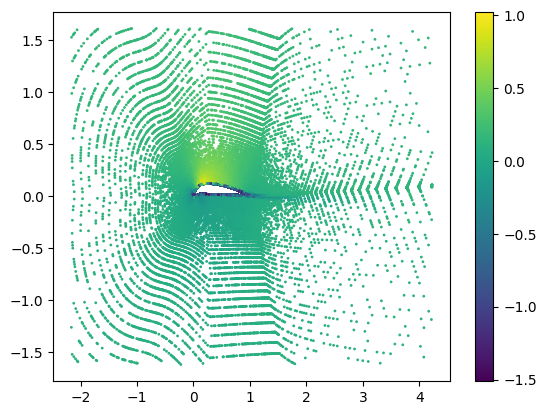

In [44]:
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=vx_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vx_pred_train_2.png', dpi=500)

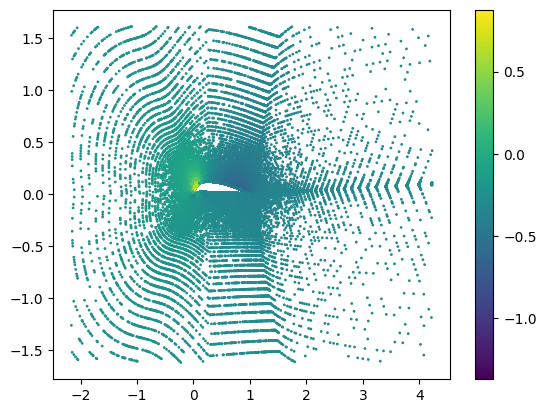

In [45]:
# vy
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.vy.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vy_gt_train_2.png', dpi=500)

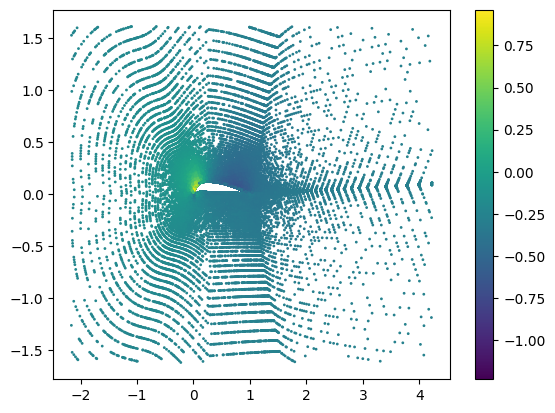

In [46]:
# vy
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=vy_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vy_pred_train_2.png', dpi=500)

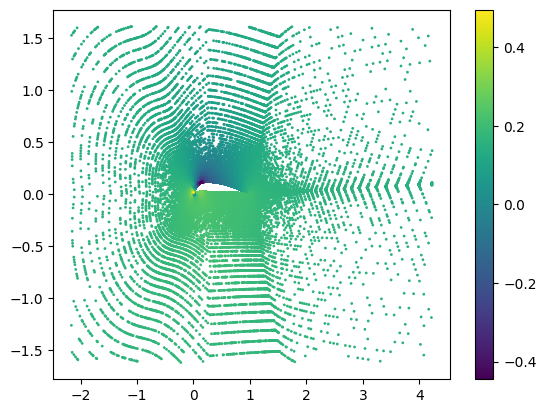

In [47]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.p.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/p_gt_train_2.png', dpi=500)

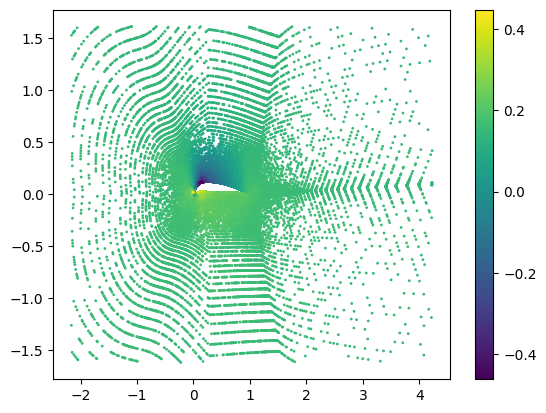

In [48]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=p_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/p_pred_train_2.png', dpi=500)

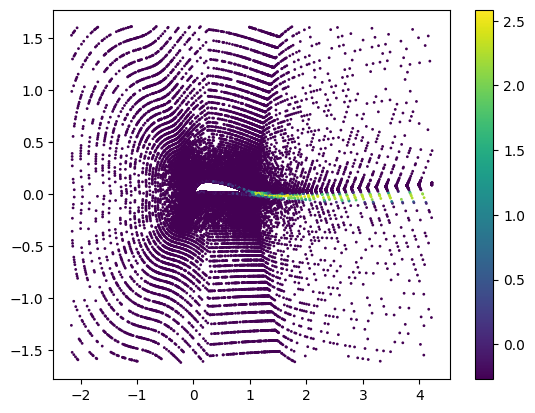

In [49]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.nu.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/nu_gt_train_2.png', dpi=500)

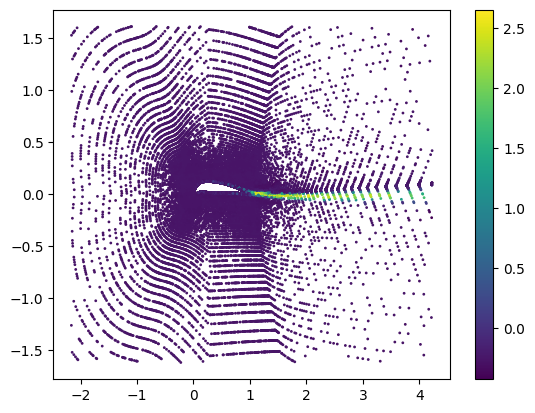

In [50]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=nu_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/nu_pred_train_2.png', dpi=500)

In [18]:
# val results

In [52]:
code_train_mse = 0
code_test_mse = 0
vx_train_mse = 0
vx_test_mse = 0
vy_train_mse = 0
vy_test_mse = 0
p_train_mse = 0
p_test_mse = 0
nu_train_mse = 0
nu_test_mse = 0
step=0
step_show = step % 100 == 0

for substep, (graph, idx) in enumerate(test_loader):
    model.eval()
    graph = graph.cuda()
    n_samples = len(graph)
    
    with torch.no_grad():
        pred = model(graph)
        
    loss = ((pred - graph.z)**2).mean()
    code_test_mse += loss.item() * n_samples

    graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    z_pred = pred.reshape(-1, 4, latent_dim)
    z_vx_pred = z_pred[:, 0, :] * sigma_vx + mu_vx
    z_vy_pred = z_pred[:, 1, :] * sigma_vy + mu_vy
    z_p_pred = z_pred[:, 2, :] * sigma_p + mu_p
    z_nu_pred = z_pred[:, 3, :] * sigma_nu + mu_nu

    with torch.no_grad():
        vx_pred = inr_vx.modulated_forward(graph.pos, z_vx_pred[graph.batch])
        vy_pred = inr_vy.modulated_forward(graph.pos, z_vy_pred[graph.batch])
        p_pred = inr_p.modulated_forward(graph.pos, z_p_pred[graph.batch])
        nu_pred = inr_nu.modulated_forward(graph.pos, z_nu_pred[graph.batch])

    vx_test_mse += ((vx_pred - graph.vx)**2).mean().item()*n_samples
    vy_test_mse += ((vy_pred - graph.vy)**2).mean().item()*n_samples
    p_test_mse += ((p_pred - graph.p)**2).mean().item()*n_samples
    nu_test_mse += ((nu_pred - graph.nu)**2).mean().item()*n_samples

code_test_loss = code_test_mse / nval
vx_test_mse = vx_test_mse / nval
vy_test_mse = vy_test_mse / nval
p_test_mse = p_test_mse / nval
nu_test_mse = nu_test_mse / nval
print("test", step, code_test_loss)

test 0 0.0179769051814219


In [ ]:
import os
os.makedirs("/home/serrano/Projects/infinity/experiments/notebooks/plots/")

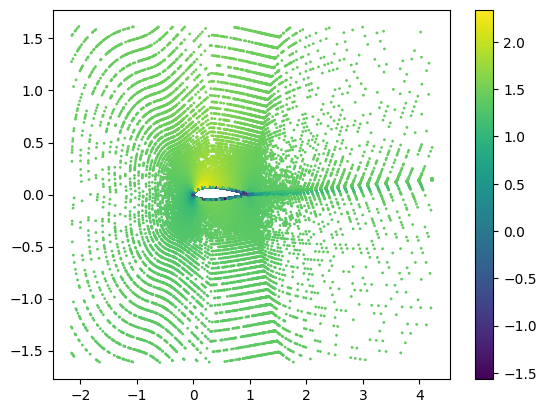

In [53]:
# vx
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.vx.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vx_gt_test_2.png', dpi=500)

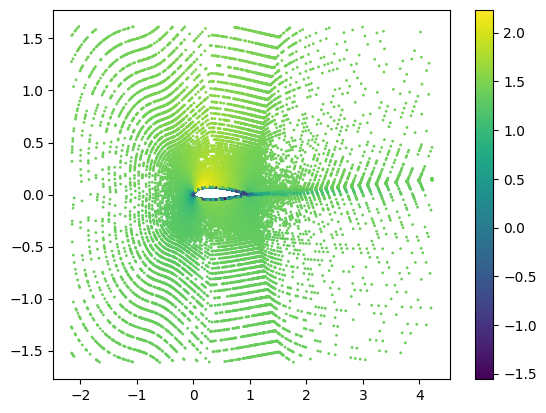

In [54]:
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=vx_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vx_pred_test_2.png', dpi=500)

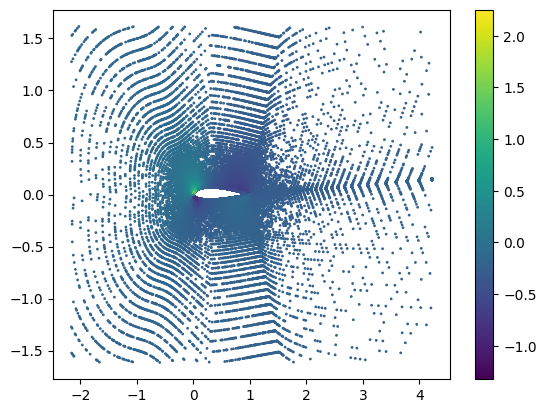

In [55]:
# vy
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.vy.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vy_gt_test_2.png', dpi=500)

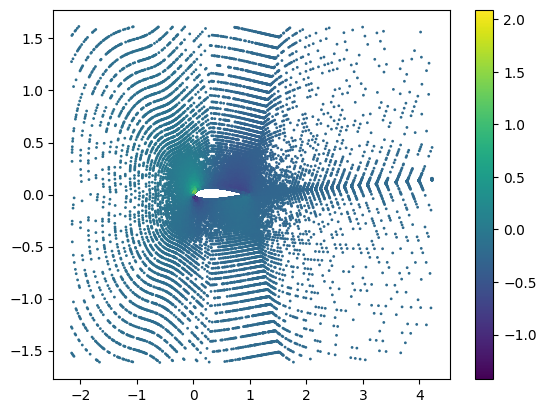

In [56]:
# vy
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=vy_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vy_pred_test_2.png', dpi=500)

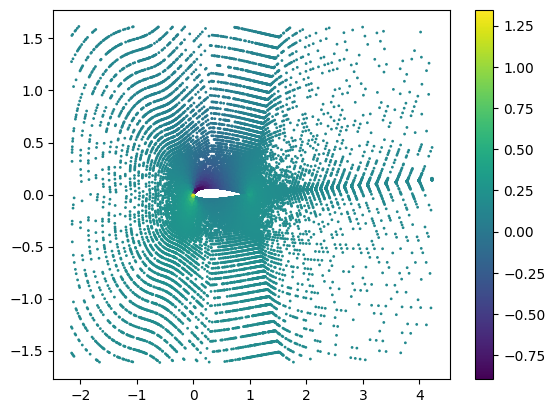

In [57]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.p.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/p_gt_test_2.png', dpi=500)

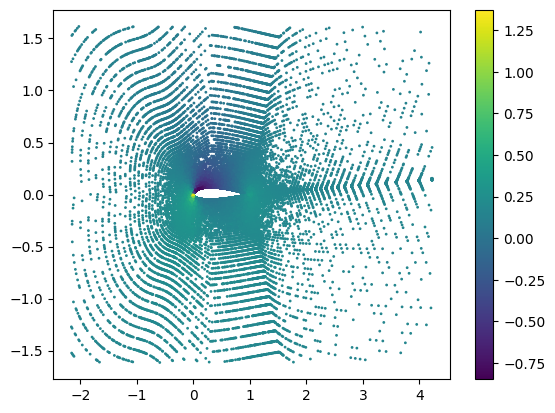

In [58]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=p_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/p_pred_test_2.png', dpi=500)

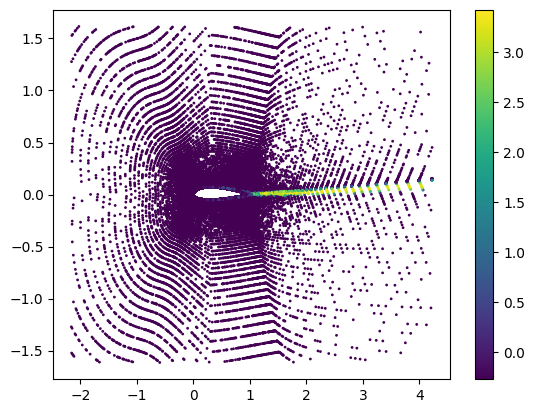

In [59]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.nu.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/nu_gt_test_2.png', dpi=500)

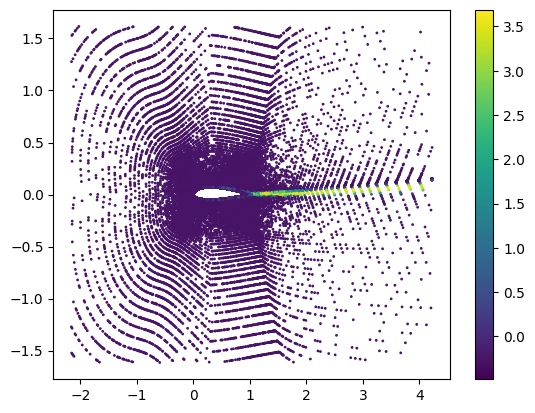

In [60]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=nu_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/nu_pred_test_2.png', dpi=500)

In [61]:
vx_test_mse

0.004273039177860483

In [62]:
vy_test_mse

0.005369530408643186

In [63]:
p_test_mse

0.014930243535491172

In [64]:
nu_test_mse

0.01556197827012511

In [65]:
p_pred.shape

torch.Size([64000, 1])